#### CPS matching observations one year apart

April 11, 2019

----

To Do:

Refactor and clean up code. Add comments. Parameterize!

Refactoring:

* Read cps feather file only once per year.

* Filter dataframe columns when reading.

In [1]:
# Import packages and set preliminaries
import pandas as pd
print('pandas:', pd.__version__)
import numpy as np
print('numpy:', np.__version__)
import os

os.chdir('/home/brian/Documents/CPS/')

pandas: 0.24.2
numpy: 1.17.2


In [2]:
# Calculate unemployed to work flow
data = pd.DataFrame()

# For each year calculate change over year before
for year in list(range(1995, 2020)):

    # Load year one
    df1 = (pd.read_feather(f'data/clean/cps{year-1}.ft')
             .query('MIS < 5 and 23 <= AGE <= 57'))

    # Generate flow1 variable
    df1['flow1'] = np.where(df1['LFS'] == 'Unemployed', 1, 0)

    # Generate unique ID
    df1['UID'] = (df1['STATE'].astype(str) + 
                  df1['HHID'].astype(str) + 
                  df1['HHID2'].astype(str) + 
                  df1['PULINENO'].astype(str))

    # Filter column-wise
    df1 = df1[['UID','MONTH','YEAR','MIS','AGE','flow1', 'BASICWGT',
               'FEMALE','WBHAO','STATE']]

    # Load year two
    df2 = (pd.read_feather(f'data/clean/cps{year}.ft')
             .query('MIS > 4 and 23 <= AGE <= 57'))

    # Generate flow2 variable
    df2['flow2'] = np.where(df2['LFS'] == 'Employed', 1, 0)

    # Generate unique ID
    df2['UID'] = (df2['STATE'].astype(str) + 
                  df2['HHID'].astype(str) + 
                  df2['HHID2'].astype(str) + 
                  df2['PULINENO'].astype(str))

    # Filter column-wise
    df2 = df2[['UID','MONTH','YEAR','MIS','AGE','flow2', 'BASICWGT',
               'FEMALE','WBHAO','STATE']]

    # List of months to loop over 
    mos = list(range(1, max(df2['MONTH']) + 1))

    # Loop over the months
    for mo in mos:
        # Generate merge groups
        g1 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 1)]
        g5 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 5)]
        g2 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 2)]
        g6 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 6)]
        g3 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 3)]
        g7 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 7)]
        g4 = df1[(df1['MONTH'] == mo) & (df1['MIS'] == 4)]
        g8 = df2[(df2['MONTH'] == mo) & (df2['MIS'] == 8)]    

        # Naive merge
        naive = (pd.merge(g1, g5, on='UID', how='inner').append(
                 pd.merge(g2, g6, on='UID', how='inner')).append(
                 pd.merge(g3, g7, on='UID', how='inner')).append(
                 pd.merge(g4, g8, on='UID', how='inner')))    

        # Filter by SRA
        mdata = naive[(naive['FEMALE_x'] == naive['FEMALE_y']) &
                      (naive['WBHAO_x'] == naive['WBHAO_y']) &
                      ((naive['AGE_x'] <= naive['AGE_y'] + 1) |
                      (naive['AGE_y'] >= naive['AGE_x']))]   

        mdata = mdata[mdata['AGE_y'].between(25, 54)]
        
        # Calculate outflow
        of = mdata[(mdata['flow1']==1) & (mdata['flow2']==1)]['BASICWGT_y'].sum()

        # Calculate total
        tot = mdata[(mdata['flow1']==1)]['BASICWGT_y'].sum()

        # Print share
        data.at[pd.to_datetime(f'{year}-{mo}-01'), 'Share'] = (of/tot) * 100

/home/brian/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in float_scalars


In [3]:
%matplotlib inline
result = data.rolling(12).mean().dropna()

In [4]:
result.iloc[-1].round(1).values[0]

54.5

In [5]:
date_text = result.iloc[-1].name.strftime('%b %Y')
value_text = result.iloc[-1].round(1).values[0]


In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

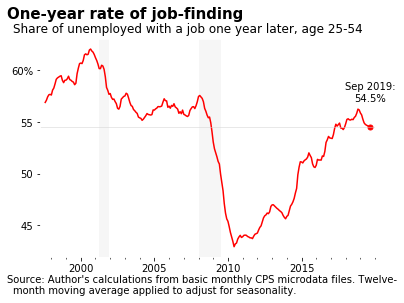

In [7]:
# Graph results
offset = pd.DateOffset(months=4)
result.plot(color='red', legend=None, figsize=(6, 4), zorder=2)
plt.xlim(result.index[0] - offset, result.index[-1] + offset)
for i, v in rec_dt:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='lightgray', alpha=0.2, zorder=1)
plt.scatter([result.index[-1]], [result.iloc[-1]], color='red', s=25)
date_text = result.iloc[-1].name.strftime('%b %Y')
value_text = result.iloc[-1].round(1).values[0]
plt.text(result.index[-1], 57, f'{date_text}:\n{value_text}%', ha='center')
plt.yticks([45.0, 50.0, 55.0, 60.0], ['45', '50', '55', '60%'])
plt.xticks(['2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01'], ['2000', '2005', '2010', '2015'])
plt.axhline(y=result.iloc[-1].values[0], color='lightgray', linewidth=0.5)    

# add title and footer
plt.text('1995-01-01', 65, 'One-year rate of job-finding', 
          fontsize=15, weight='bold')

plt.text('1995-06-01', 63.7, "Share of unemployed with a job one year later, age 25-54", 
          fontsize=12)

plt.text('1995-01-01', 39.5, "Source: Author's calculations from basic monthly CPS microdata files. Twelve-")
plt.text('1995-06-01', 38.4, 'month moving average applied to adjust for seasonality.')

plt.savefig('Jobfinding.png', bbox_inches='tight')

plt.show()